In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import random

from scipy.integrate import solve_ivp
import torch 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import pysindy as ps

# Генерация данных как в CRNN-модели

### Функция для вычисления приращений концентраций веществ

In [3]:
def true_ode_func(t, y, k):
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.zeros_like(y)
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

### Константы

In [4]:
N_REACTION = 4                                                       # кол-во реакций
N_SUBSTANCE = 5                                                      # кол-во веществ
VR_TIME = 30                                                         # время протекания реакций
INIT_CONC = np.array([0.8, 0.5, 0.1, 0, 0])                          # начальные концентрации веществ
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)         # константы скоростей реакций

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], VR_TIME + 1)                # шаги по временному промежутку (количество точек)

Стехиометрическая матрица (матрица реакций) в базовом виде

In [5]:
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

### Вычисление и визуализация изменения концентраций веществ со временем

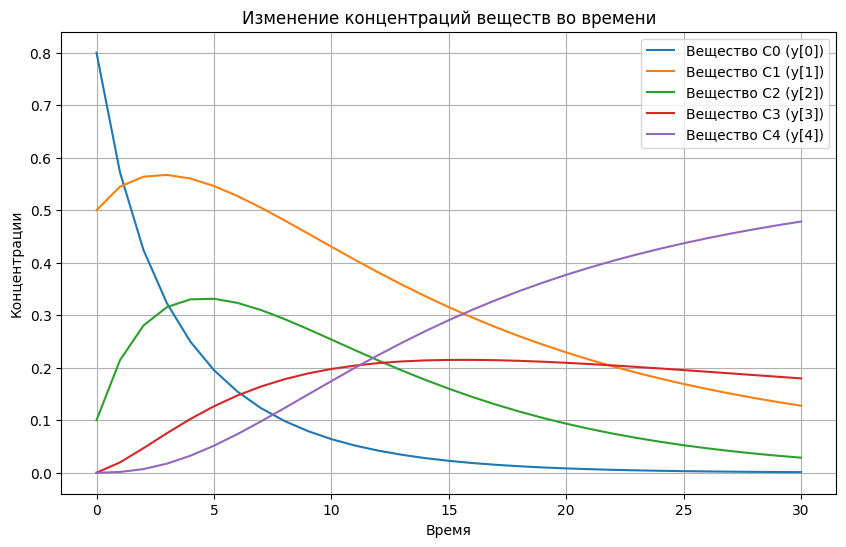

Начальные концентрации:        [0.8 0.5 0.1 0.  0. ]
Сумма концентраций веществ:    1.4000000000000001
Концентрации после 30 секунд:  [0.00135553 0.1347056  0.03239029 0.18281589 0.47134237]
Сумма концентрций веществ:     0.8226096690921885


In [6]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", INIT_CONC)
print("Сумма концентраций веществ:   ", sum(INIT_CONC))
print(f"Концентрации после {VR_TIME} секунд:  {sol.y[:, VR_TIME - 1]}")
print("Сумма концентрций веществ:    ", sum(sol.y[:, VR_TIME - 1]))

In [7]:
true_values = sol.y.copy()    # сохранение промежуточных результатов. Понадобятся в будущем

# Добавление шума

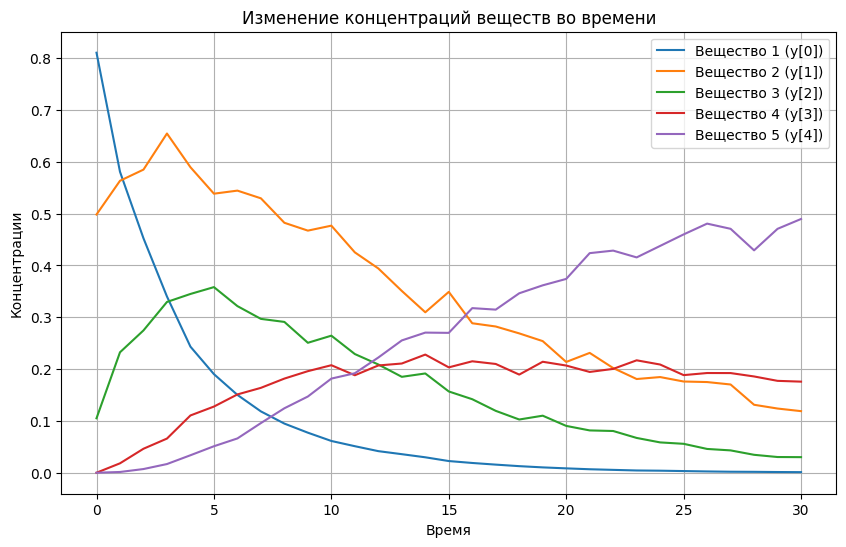

In [8]:
# Генерация шума
noise_level = 5e-2                # Уровень шума
time_vec = sol.t.reshape(-1, 1)   # Изменение формата временного шага для метода из sklearn

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    noise = np.random.randn(*sol.y[i].shape) * sol.y[i] * noise_level
    sol.y[i] = sol.y[i] + noise
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


# Построение полиномиальных аппроксимаций функций изменения концентраций

Полином 0-го вещества:  [ 0.00000000e+00 -2.47198875e-01  3.97444466e-02 -4.11533940e-03
  2.87600877e-04 -1.34472545e-05  3.99966077e-07 -6.78180244e-09
  4.95498642e-11]
свободный коэффициент:  0.8063103924674252
Полином 1-го вещества:  [ 0.00000000e+00  1.12874926e-01 -3.84698432e-02  5.74176814e-03
 -5.01537134e-04  2.61942435e-05 -7.98713915e-07  1.30895439e-08
 -8.90878621e-11]
свободный коэффициент:  0.4934226393468569
Полином 2-го вещества:  [ 0.00000000e+00  1.41326149e-01 -2.86468517e-02  2.23223231e-03
 -4.23793241e-05 -4.91759418e-06  3.61713665e-07 -9.54907434e-09
  9.17094733e-11]
свободный коэффициент:  0.1067283272856053
Полином 3-го вещества:  [ 0.00000000e+00  8.38697930e-03  1.06249868e-02 -2.36067793e-03
  2.49816925e-04 -1.54787712e-05  5.66628997e-07 -1.12634061e-08
  9.31885333e-11]
свободный коэффициент:  0.0003409138069339346
Полином 4-го вещества:  [ 0.00000000e+00 -1.79723012e-03  3.02423178e-03 -2.95068467e-04
  5.93281110e-05 -7.26006753e-06  4.19655362e-07

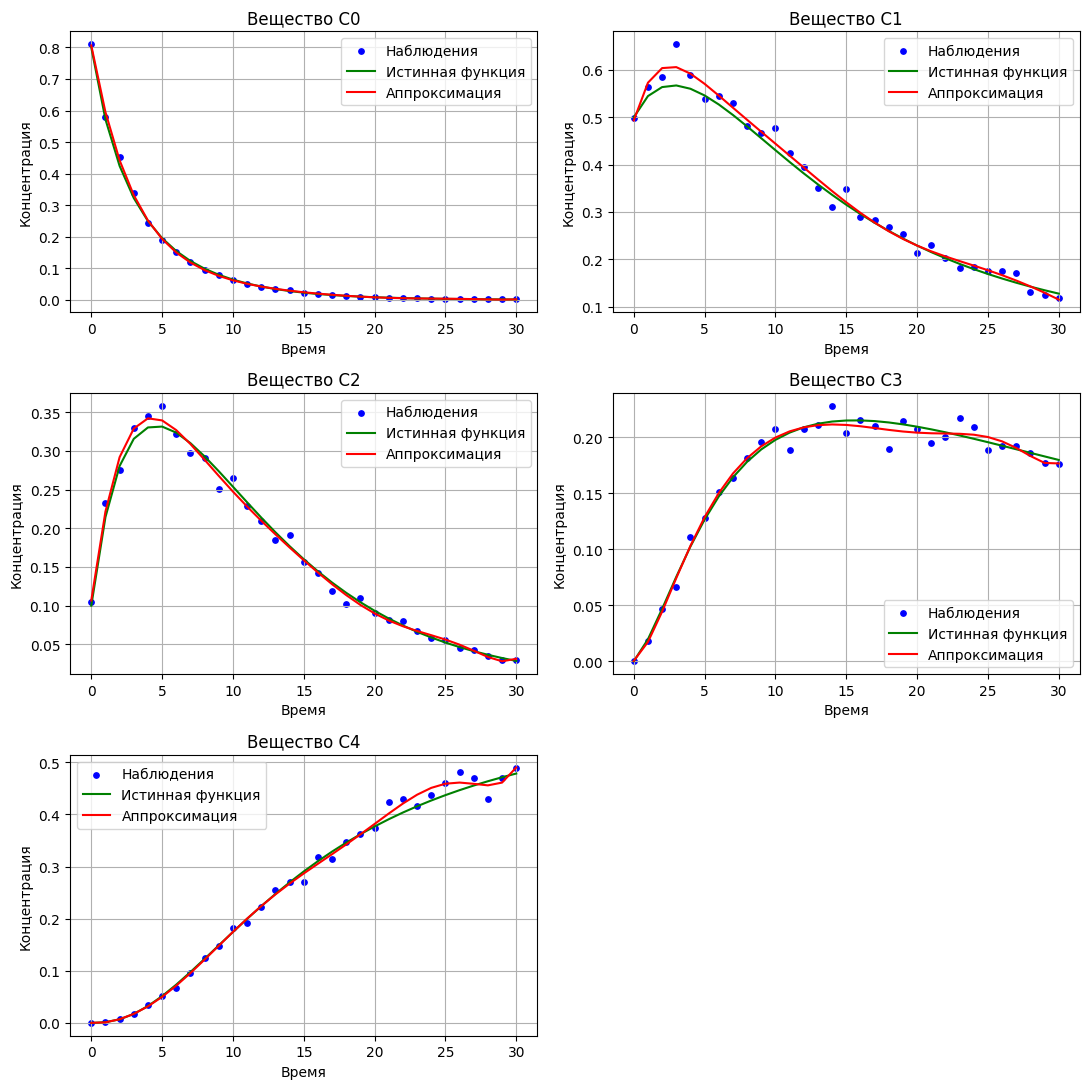

In [9]:
# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree=8)
t_poly = poly.fit_transform(time_vec)

# Определяем количество строк и столбцов для сетки графиков
rows, cols = (3, 2)  # Подходит для N_SUBSTANCE = 6
fig, axes = plt.subplots(rows, cols, figsize=(11,11))  # Размер общего окна

reaction_poly_coeffs = np.zeros((5, 9))  # Массив из 5 строк и 9 столбцов. Тут будут храниться коэффициенты полиномов 
                                         # Столбцы отвечают за количество коэффициентов полинома,строки за концентрации веществ

# Перебираем вещества и оси для графиков
for i in range(N_SUBSTANCE):
    y = sol.y[i].reshape(-1, 1)  # значения функции как 2D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Определяем текущую ось
    ax = axes[i // cols, i % cols]
    
    # Строим график
    ax.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    ax.plot(sol.t, true_values[i], color='green', label=f'Истинная функция')
    ax.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    ax.set_title(f'Вещество C{i}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Концентрация')
    ax.legend()
    ax.grid()

    # Сохранение полиномов
    reaction_poly_coeffs[i, :] = model.coef_[0]
    print(f'Полином {i}-го вещества: ', model.coef_[0])
    print(f'свободный коэффициент: ', model.intercept_[0])
    reaction_poly_coeffs[i][0] = model.intercept_[0]

# Убираем пустые графики, если их больше нет
for j in range(N_SUBSTANCE, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()  # Автоматическая подгонка расстояний
plt.show()


Здесь первый элемент `model.coef_[0]` = `0.00000000e+00` соответствует \(x^0\). Он, равен `0`, так как свободный член отдельно хранится в `model.intercept_`.

### Визуализация полиномов в более презентабельном виде

In [10]:
# Функция для форматирования полинома
def format_polynomial(coefficients):
    terms = []
    for power, coef in enumerate(coefficients):
        if abs(coef) > 1e-10:  # Пропускать практически нулевые коэффициенты
            term = f"{coef:.5e}" if power == 0 else f"{coef:.5e}*t^{power}"
            terms.append(term)
    return " + ".join(terms).replace("+ -", "- ")  # Убираем лишние плюсы перед отрицательными числами

# Генерация и вывод полиномов
for i, coeffs in enumerate(reaction_poly_coeffs):
    print(f"C{i}(t) = ", end='')
    print(format_polynomial(coeffs))


C0(t) = 8.06310e-01 - 2.47199e-01*t^1 + 3.97444e-02*t^2 - 4.11534e-03*t^3 + 2.87601e-04*t^4 - 1.34473e-05*t^5 + 3.99966e-07*t^6 - 6.78180e-09*t^7
C1(t) = 4.93423e-01 + 1.12875e-01*t^1 - 3.84698e-02*t^2 + 5.74177e-03*t^3 - 5.01537e-04*t^4 + 2.61942e-05*t^5 - 7.98714e-07*t^6 + 1.30895e-08*t^7
C2(t) = 1.06728e-01 + 1.41326e-01*t^1 - 2.86469e-02*t^2 + 2.23223e-03*t^3 - 4.23793e-05*t^4 - 4.91759e-06*t^5 + 3.61714e-07*t^6 - 9.54907e-09*t^7
C3(t) = 3.40914e-04 + 8.38698e-03*t^1 + 1.06250e-02*t^2 - 2.36068e-03*t^3 + 2.49817e-04*t^4 - 1.54788e-05*t^5 + 5.66629e-07*t^6 - 1.12634e-08*t^7
C4(t) = 1.88360e-04 - 1.79723e-03*t^1 + 3.02423e-03*t^2 - 2.95068e-04*t^3 + 5.93281e-05*t^4 - 7.26007e-06*t^5 + 4.19655e-07*t^6 - 1.13613e-08*t^7 + 1.16896e-10*t^8


Нахождение производных от функций концентраций веществ

Так как в нашем случае в качестве функций используются только полиномы, то я напишу функцию вручную

`print(reaction_poly_coeffs)` - чтобы посмотреть массив с коэффициентами полиномов для каждого вещества

In [11]:
def differentiate_polynomial(coefficients):
    degree = len(coefficients) # степень полинома + 1
    return np.array([coefficients[i] * i for i in range(1, degree)])

reaction_poly_derivatives = np.array([differentiate_polynomial(coeff) for coeff in reaction_poly_coeffs])

print(reaction_poly_derivatives)

[[-2.47198875e-01  7.94888931e-02 -1.23460182e-02  1.15040351e-03
  -6.72362724e-05  2.39979646e-06 -4.74726170e-08  3.96398914e-10]
 [ 1.12874926e-01 -7.69396864e-02  1.72253044e-02 -2.00614854e-03
   1.30971217e-04 -4.79228349e-06  9.16268074e-08 -7.12702897e-10]
 [ 1.41326149e-01 -5.72937034e-02  6.69669692e-03 -1.69517296e-04
  -2.45879709e-05  2.17028199e-06 -6.68435204e-08  7.33675787e-10]
 [ 8.38697930e-03  2.12499737e-02 -7.08203378e-03  9.99267699e-04
  -7.73938562e-05  3.39977398e-06 -7.88438429e-08  7.45508266e-10]
 [-1.79723012e-03  6.04846356e-03 -8.85205402e-04  2.37312444e-04
  -3.63003376e-05  2.51793217e-06 -7.95289663e-08  9.35165128e-10]]


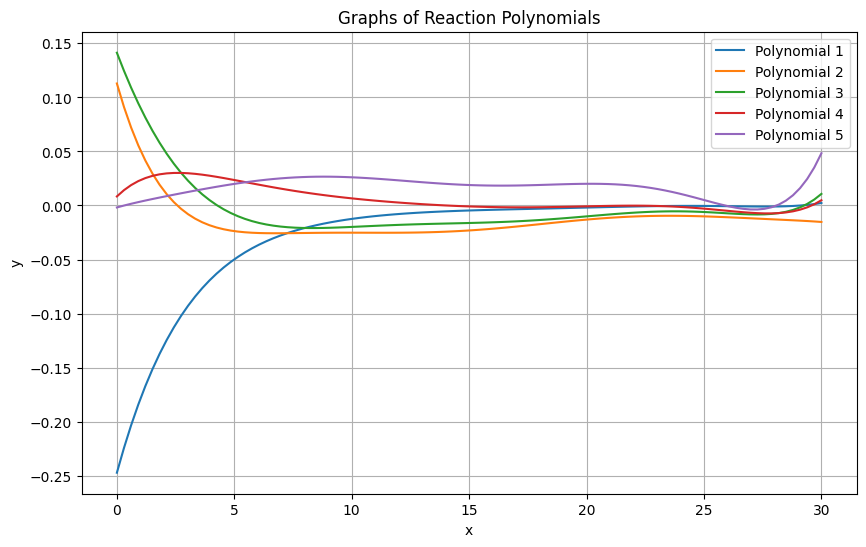

In [12]:
# Диапазон значений x
x = np.linspace(0, 30, 100)

# Построение графиков
plt.figure(figsize=(10, 6))
for i, coeffs in enumerate(reaction_poly_derivatives):
    y = np.polyval(coeffs[::-1], x)  # Вычисляем значения полинома
    plt.plot(x, y, label=f'Polynomial {i+1}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphs of Reaction Polynomials')
plt.legend()
plt.grid()
plt.show()


[8.06310392e-01 7.34939146e-01 6.70213003e-01 6.11527185e-01
 5.58327342e-01 5.10105957e-01 4.66398954e-01 4.26782500e-01
 3.90869985e-01 3.58309188e-01 3.28779607e-01 3.01989955e-01
 2.77675810e-01 2.55597420e-01 2.35537647e-01 2.17300048e-01
 2.00707091e-01 1.85598491e-01 1.71829666e-01 1.59270308e-01
 1.47803057e-01 1.37322283e-01 1.27732958e-01 1.18949619e-01
 1.10895427e-01 1.03501292e-01 9.67050847e-02 9.04509159e-02
 8.46884844e-02 7.93724852e-02 7.44620778e-02 6.99204075e-02
 6.57141780e-02 6.18132694e-02 5.81903989e-02 5.48208216e-02
 5.16820655e-02 4.87537002e-02 4.60171342e-02 4.34554393e-02
 4.10531972e-02 3.87963683e-02 3.66721782e-02 3.46690198e-02
 3.27763693e-02 3.09847138e-02 2.92854879e-02 2.76710186e-02
 2.61344754e-02 2.46698254e-02 2.32717913e-02 2.19358104e-02
 2.06579955e-02 1.94350938e-02 1.82644458e-02 1.71439418e-02
 1.60719755e-02 1.50473954e-02 1.40694521e-02 1.31377431e-02
 1.22521536e-02 1.14127944e-02 1.06199366e-02 9.87394446e-03
 9.17520530e-03 8.524059

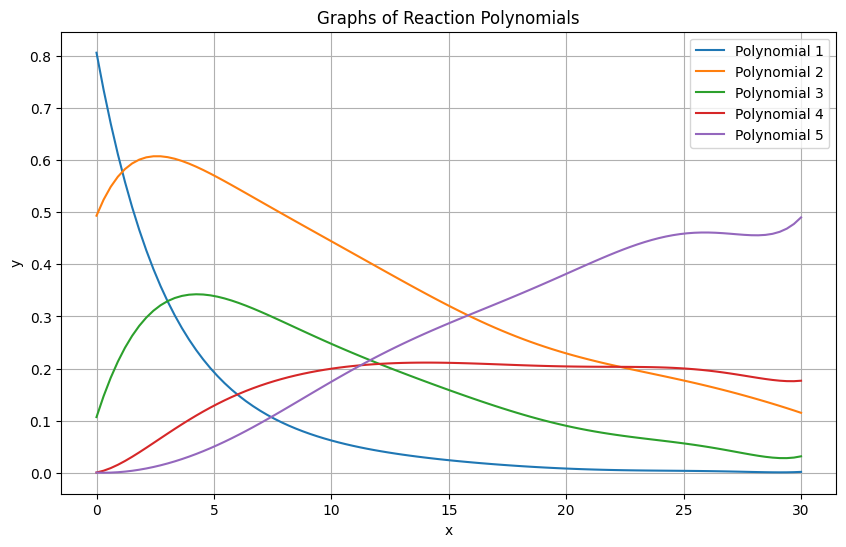

In [13]:
# Диапазон значений x
t = np.linspace(0, 30, 100)

# Построение графиков
plt.figure(figsize=(10, 6))
for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], t)  # Вычисляем значения полинома
    print(y)
    plt.plot(t, y, label=f'Polynomial {i+1}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphs of Reaction Polynomials')
plt.legend()
plt.grid()
plt.show()



# Вычисление k - константы скорости реакции

По формуле:

<div style="text-align: center;">

$$\frac{d\vec{C}}{dt}=S\cdot\vec{W}$$

</div>

Имеется зависимость между 3 переменными, две из которых мы знаем. Остается выразить $\vec{W}$ из этого уравнения, и получить его численно

В ходе преобразований получается:

<div style="text-align: center;">

$$\vec{W} = (S^\top S)^{-1} S^\top\frac{d\vec{C}}{dt}$$

</div>

А это уже МНК. Посчитаю вектор приращений в точке

In [14]:
# Точка в которой считаем значения
t_1 = 0.5
t_2 = 6
t_3 = 15

# Вычисление значения полиномов в точке t
dC_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_derivatives])
dC_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_derivatives])
dC_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_derivatives])

print('Производные концентраций в моменты времени:')
print('dC(t=0.5) = ', dC_1)
print('dC(t=6)   = ', dC_2)
print('dC(t=12)  = ', dC_3)

# Вычисление значения скоростей реакций в моменты времени
W_1 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_1  # t_1 = 0.5
W_2 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_2  # t_2 = 6
W_3 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_3  # t_3 = 12

print()
print('Вектора скоростей реакций в моменты времени:')
print('W(t=0.5) = ', W_1)
print('W(t=6)   = ', W_2)
print('W(t=12)  = ', W_3)

# Вычисление концентраций веществ в моменты времени
C_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_coeffs])
C_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_coeffs])
C_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_coeffs])

print()
print('Концентрации в моменты времени:')
print('C(t=0.5) = ', C_1)
print('C(t=6)   = ', C_2)
print('C(t=12)  = ', C_3)

Производные концентраций в моменты времени:
dC(t=0.5) =  [-0.21040126  0.07846868  0.11433081  0.01736163  0.00103317]
dC(t=6)   =  [-0.03681632 -0.02543099 -0.01587388  0.01943979  0.02297113]
dC(t=12)  =  [-0.00461289 -0.02308594 -0.0161857  -0.00085671  0.01893525]

Вектора скоростей реакций в моменты времени:
W(t=0.5) =  [ 0.05408683  0.1073106  -0.00193721 -0.01421584]
W(t=6)   =  [0.00228983 0.03128672 0.04621067 0.02582094]
W(t=12)  =  [-0.0007065   0.00533704  0.0208339   0.02100177]

Концентрации в моменты времени:
C(t=0.5) =  [6.92150210e-01 5.40929822e-01 1.70505921e-01 6.91070404e-03
 1.24071534e-05]
C(t=6)   =  [0.15001437 0.54592387 0.32675494 0.15009582 0.07157283]
C(t=12)  =  [0.02396278 0.32053367 0.1587488  0.21090145 0.28674407]


Далее по формуле: 
<div style="text-align: center;">

$$\vec{W}=\vec{k}\prod_{i=0}^n C_i^{S_{ij}^+}$$

</div>

In [15]:
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


In [16]:
# Вычисление вектора с использованием заданной формулы
result_1 = np.prod(C_1 ** MATR_PLUS, axis=1)
result_2 = np.prod(C_2 ** MATR_PLUS, axis=1)
result_3 = np.prod(C_3 ** MATR_PLUS, axis=1)

In [17]:
print(f'k(t={t_1}) = {W_1/result_1}')
print(f'k(t={t_2}) = {W_2/result_2}')
print(f'k(t={t_3}) = {W_3/result_3}')
print()
print('Истинные значения:' ,k)

k(t=0.5) = [ 0.11289919  0.15503947 -0.01136153 -3.8028505 ]
k(t=6) = [0.10175074 0.20855817 0.14142301 0.31511669]
k(t=15) = [-1.23036998  0.22272209  0.13123816  0.31067241]

Истинные значения: tensor([0.1000, 0.2000, 0.1300, 0.3000])
